In [3]:
!pip install split-folders

In [4]:
import os
import torchvision
import torch
import time
import matplotlib
import splitfolders
import matplotlib.pyplot as plt
import numpy as np

from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [5]:
print(torch.__version__)

1.9.1


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
data_dir = '../input/braintumor/Datasets(2)'
classes = os.listdir(data_dir + "/Training")

print('Classes:')
for idx, train_class in enumerate(classes):
    print(f'{idx+1}. {train_class}')

Classes:
1. no_tumor
2. tumor


In [8]:
size_traning = 0

print('Datasets traning size:')
for idx,train_class in enumerate(classes):
  size  = len(os.listdir(data_dir + f"/Training/{train_class}"))
  size_traning += size
  print(f'{idx+1}. {train_class} {size}')
print(f'Sum {size_traning}')

Datasets traning size:
1. no_tumor 499
2. tumor 520
Sum 1019


In [9]:
splitfolders.ratio('../input/braintumor/Datasets(2)/Training', output='datsets', ratio=(0.8, 0.1003, 0.0997))

Copying files: 1019 files [00:06, 168.72 files/s]


In [10]:
image_size = (224,224)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])


dataset_training = ImageFolder('/kaggle/working/datsets/train/', transform=transform)
dataset_validating = ImageFolder('/kaggle/working/datsets/val/', transform=transform)
dataset_testing = ImageFolder('/kaggle/working/datsets/test/', transform=transform)

print(f'Size train {len(dataset_training)}')
print(f'Size val {len(dataset_validating)}')
print(f'Size test {len(dataset_testing)}')

Size train 815
Size val 102
Size test 102


In [11]:
img, label = dataset_training[0]
print(f'Input shape: {img.shape}')

Input shape: torch.Size([3, 224, 224])


In [12]:
batch_size=16
train_loader = DataLoader(dataset_training, batch_size=batch_size,shuffle=True)
val_loader =  DataLoader(dataset_validating,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(dataset_testing,batch_size=batch_size,shuffle=False)

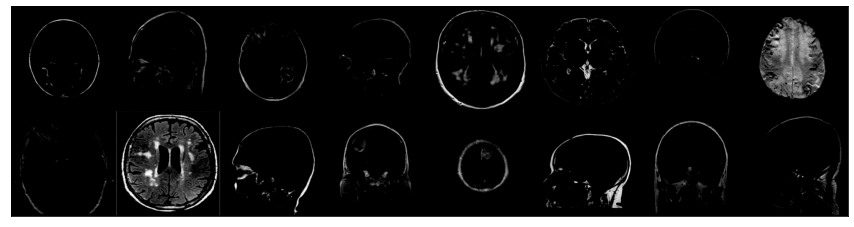

In [13]:
examples = iter(train_loader)
img,labels = examples.next()
def show_batch(dataset_loader):
    _, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img).permute(1, 2, 0))
show_batch(train_loader)

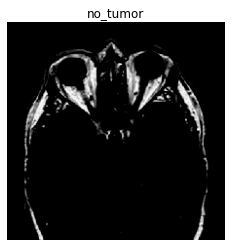

In [14]:
def show_image(img, label):
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'{dataset_training.classes[label]}')
    plt.axis("off")
    plt.show()

show_image(*dataset_training[0])

In [15]:
def training_step(model, batch):
    images, labels = batch
    if torch.cuda.is_available():
        images=images.to(device)
        labels=labels.to(device)
    out = model(images)  
    loss = F.cross_entropy(out, labels)  
    acc = accuracy(out, labels) 
    return {'train_loss': loss,'train_acc':acc}

def validation_step(model, batch):
    images, labels = batch
    if torch.cuda.is_available():
        images=images.to(device)
        labels=labels.to(device)
    out = model(images)  
    loss = F.cross_entropy(out, labels)  
    acc = accuracy(out, labels)  
    return {'val_loss': loss.detach(), 'val_acc': acc}

def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() 
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()  
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(epoch, result):
    print("Epoch [{}], time(s): {:.4f}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['epoch_time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

def test_step(model, batch):
    images, labels = batch
    if torch.cuda.is_available():
        images=images.to(device)
        labels=labels.to(device)
    out = model(images)  
    acc = accuracy(out, labels) 
    return {'y_test': labels, 'prediction': out}

def test_end(outputs, name):
    y_test = [y.item() for x in outputs for y in x['y_test'] ]
    y_prediction = [torch.argmax(y).item() for x in outputs for y in x['prediction']]
    
    report = classification_report(y_test, y_prediction, target_names=dataset_training.classes)
    print(f'Test {name} Pytorch')
    print(f'{report}')
    
    fig, ax = plt.subplots(figsize=(10, 10)) 
    ax.set_title(f'Confusion Matrix {name} Pytorch')
    cm = confusion_matrix(y_test,y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dataset_training.classes)
    disp.plot(cmap='Blues', ax=ax)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)

@torch.no_grad()
def test(model, test_loader, name):
    model.eval()
    outputs = [test_step(model, batch) for batch in test_loader]
    return test_end(outputs, name)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        t0 = time.time()
        model.train()
        train_losses = []
        train_accuracy = []
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = training_step(model, batch)
            train_losses.append(outputs['train_loss'])
            train_accuracy.append(outputs['train_acc'])
            outputs['train_loss'].backward()
            optimizer.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        result['epoch_time'] = time.time() - t0
        epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
def display_plot(history, name):
    acc = [epoch["train_acc"] for epoch in history]
    val_acc = [epoch["val_acc"] for epoch in history]

    loss = [epoch['train_loss'] for epoch in history]
    val_loss = [epoch['val_loss'] for epoch in history]

    plt.figure(figsize=(14, 8))
    tab_plot = [{
                "id": 1,
                "variables":[acc, val_acc],
                "labels":['Training Accuracy', 'Validation Accuracy'],
                "legend":'lower right',
                "title":f'Accuracy Pytorch - {name}',
                "ylabel":'Accuracy'
            },{ 
                "id": 2,
                "variables":[loss, val_loss],
                "labels":['Training Loss', 'Validation Loss'],
                "legend":'upper right',
                "title":f'Loss Pytorch - {name}',
                "ylabel":'Loss'
            }]
    

    epochs_range = range(25)
    for tab in tab_plot: 
        plt.subplot(1, 2, tab['id'])
        plt.plot(epochs_range,  tab['variables'][0], label=tab['labels'][0], marker='o', markerfacecolor='green',color='green')
        plt.plot(epochs_range , tab['variables'][1], label=tab['labels'][1], marker='o', markerfacecolor='blue',color='blue')
        plt.legend(loc=tab['legend'])
        plt.title(tab['title'])
        plt.xlabel('Epochs')
        plt.ylabel(tab['ylabel'])
    plt.show()

In [32]:
model_mobilenet_v2 = models.mobilenet_v2(num_classes=2, pretrained=False)
model_mobilenet_v2.to(device)
model_mobilenet_v2.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [33]:
opt_func = torch.optim.Adam
lr = 0.001
print('Train Mobilenetv2 Pytorch')
history_mobilenet_v2= fit(25, lr, model_mobilenet_v2, train_loader, val_loader, opt_func)

Train Mobilenetv2 Pytorch
Epoch [0], time(s): 8.6621, train_loss: 0.4929, train_acc: 0.7597, val_loss: 2.4414, val_acc: 0.5536
Epoch [1], time(s): 8.0548, train_loss: 0.3897, train_acc: 0.8490, val_loss: 0.9988, val_acc: 0.6161
Epoch [2], time(s): 8.1114, train_loss: 0.2727, train_acc: 0.8921, val_loss: 0.3812, val_acc: 0.8631
Epoch [3], time(s): 7.8202, train_loss: 0.2878, train_acc: 0.8920, val_loss: 0.3652, val_acc: 0.8571
Epoch [4], time(s): 9.0403, train_loss: 0.2251, train_acc: 0.9251, val_loss: 0.2894, val_acc: 0.8869
Epoch [5], time(s): 8.0686, train_loss: 0.1796, train_acc: 0.9240, val_loss: 2.2712, val_acc: 0.6369
Epoch [6], time(s): 8.0220, train_loss: 0.1663, train_acc: 0.9435, val_loss: 0.3119, val_acc: 0.8780
Epoch [7], time(s): 7.7928, train_loss: 0.1324, train_acc: 0.9521, val_loss: 0.4074, val_acc: 0.8631
Epoch [8], time(s): 8.6762, train_loss: 0.1639, train_acc: 0.9449, val_loss: 0.2799, val_acc: 0.9286
Epoch [9], time(s): 8.0852, train_loss: 0.1452, train_acc: 0.9534

Test Mobilenetv2 Pytorch
              precision    recall  f1-score   support

    no_tumor       0.88      0.90      0.89        50
       tumor       0.90      0.88      0.89        52

    accuracy                           0.89       102
   macro avg       0.89      0.89      0.89       102
weighted avg       0.89      0.89      0.89       102



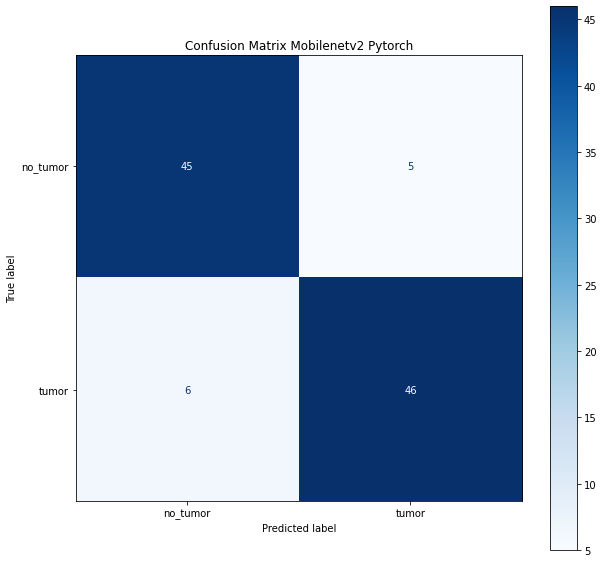

In [36]:
test(model_mobilenet_v2,test_loader, 'Mobilenetv2')

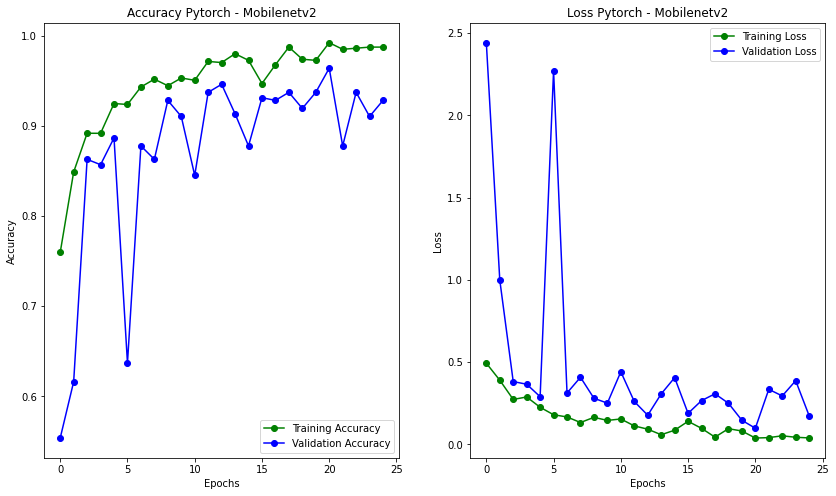

In [37]:
display_plot(history_mobilenet_v2, 'Mobilenetv2')

In [46]:
model_densenet121 = models.densenet121(num_classes=2, pretrained=False)
model_densenet121.to(device)
model_densenet121.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [47]:
print('Train DenseNet121 Pytorch')
history_densenet121 = fit(25, lr, model_densenet121, train_loader, val_loader, opt_func)

Train DenseNet121 Pytorch
Epoch [0], time(s): 13.1520, train_loss: 0.5084, train_acc: 0.7767, val_loss: 0.4786, val_acc: 0.8214
Epoch [1], time(s): 14.0054, train_loss: 0.3479, train_acc: 0.8711, val_loss: 0.4275, val_acc: 0.8214
Epoch [2], time(s): 13.1262, train_loss: 0.3112, train_acc: 0.8712, val_loss: 5.1936, val_acc: 0.4464
Epoch [3], time(s): 13.6758, train_loss: 0.3166, train_acc: 0.8871, val_loss: 2.4463, val_acc: 0.4464
Epoch [4], time(s): 13.1007, train_loss: 0.3068, train_acc: 0.8823, val_loss: 2.1139, val_acc: 0.4524
Epoch [5], time(s): 13.2364, train_loss: 0.3133, train_acc: 0.8735, val_loss: 0.2982, val_acc: 0.8393
Epoch [6], time(s): 13.9555, train_loss: 0.2892, train_acc: 0.8884, val_loss: 0.8820, val_acc: 0.5179
Epoch [7], time(s): 13.1051, train_loss: 0.2482, train_acc: 0.9056, val_loss: 0.4931, val_acc: 0.8571
Epoch [8], time(s): 13.6563, train_loss: 0.3024, train_acc: 0.8783, val_loss: 0.4643, val_acc: 0.8304
Epoch [9], time(s): 13.1114, train_loss: 0.2096, train_a

Test DenseNet121 Pytorch
              precision    recall  f1-score   support

    no_tumor       0.83      0.98      0.90        50
       tumor       0.98      0.81      0.88        52

    accuracy                           0.89       102
   macro avg       0.90      0.89      0.89       102
weighted avg       0.91      0.89      0.89       102



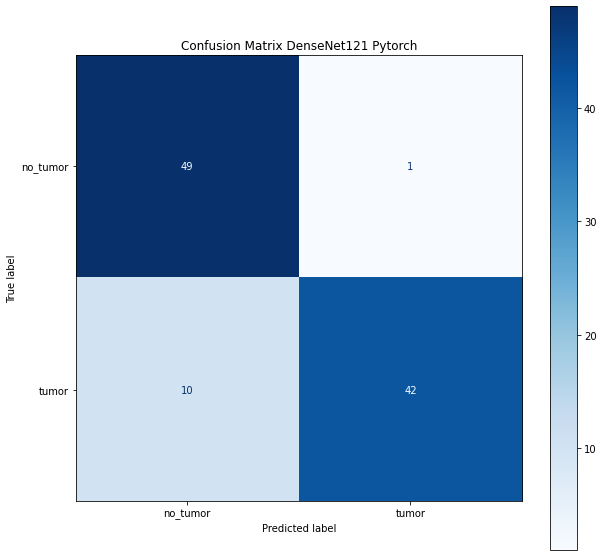

In [48]:
test(model_densenet121,test_loader, 'DenseNet121')

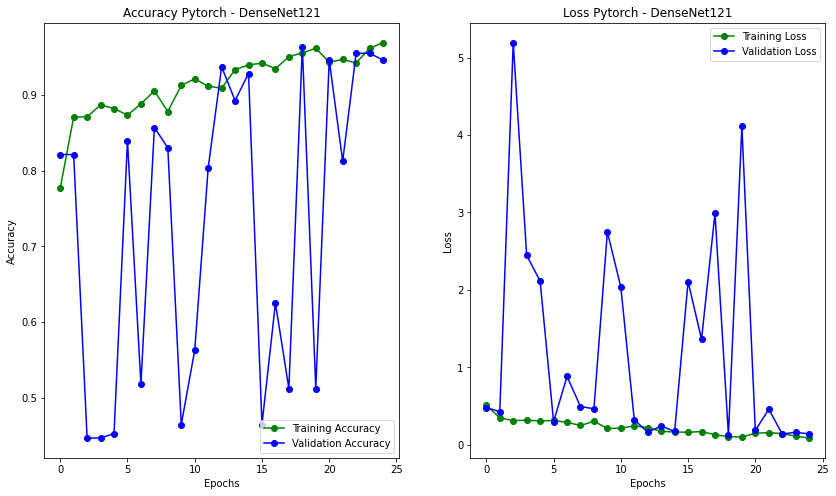

In [49]:
display_plot(history_densenet121, 'DenseNet121')

In [50]:
model_resnet50 = models.resnet50(num_classes=2, pretrained=False)
model_resnet50.to(device)
model_resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [51]:
print('Train Resnet50 Pytorch')
history_resnet50 = fit(25, lr, model_resnet50, train_loader, val_loader, opt_func)

Train Resnet50 Pytorch
Epoch [0], time(s): 10.0431, train_loss: 0.7227, train_acc: 0.7313, val_loss: 1.7189, val_acc: 0.4464
Epoch [1], time(s): 10.1316, train_loss: 0.4418, train_acc: 0.8208, val_loss: 1.5232, val_acc: 0.4702
Epoch [2], time(s): 10.5530, train_loss: 0.3680, train_acc: 0.8748, val_loss: 0.5981, val_acc: 0.7173
Epoch [3], time(s): 10.2733, train_loss: 0.3290, train_acc: 0.8774, val_loss: 1.9423, val_acc: 0.5030
Epoch [4], time(s): 10.1693, train_loss: 0.4222, train_acc: 0.8296, val_loss: 0.4343, val_acc: 0.8304
Epoch [5], time(s): 10.5226, train_loss: 0.3869, train_acc: 0.8614, val_loss: 0.8865, val_acc: 0.7262
Epoch [6], time(s): 10.1816, train_loss: 0.4380, train_acc: 0.8366, val_loss: 1.0441, val_acc: 0.7232
Epoch [7], time(s): 10.1120, train_loss: 0.3514, train_acc: 0.8735, val_loss: 1.2473, val_acc: 0.4464
Epoch [8], time(s): 10.5770, train_loss: 0.3571, train_acc: 0.8664, val_loss: 0.6361, val_acc: 0.5952
Epoch [9], time(s): 10.4976, train_loss: 0.2484, train_acc:

Test Resnet50 Pytorch
              precision    recall  f1-score   support

    no_tumor       0.79      0.96      0.86        50
       tumor       0.95      0.75      0.84        52

    accuracy                           0.85       102
   macro avg       0.87      0.85      0.85       102
weighted avg       0.87      0.85      0.85       102



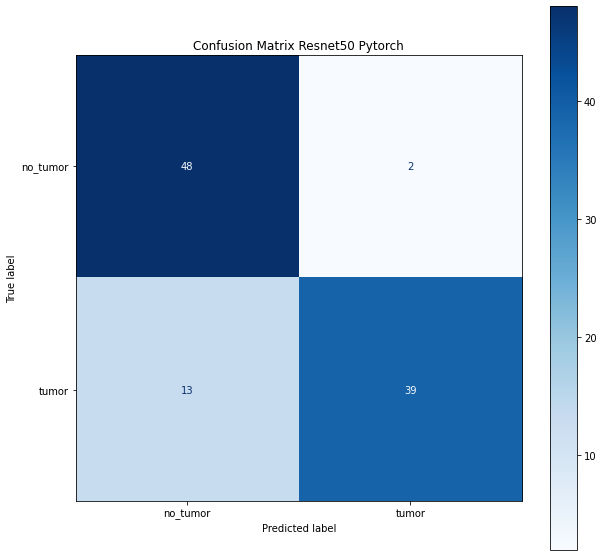

In [53]:
test(model_resnet50,test_loader, 'Resnet50')

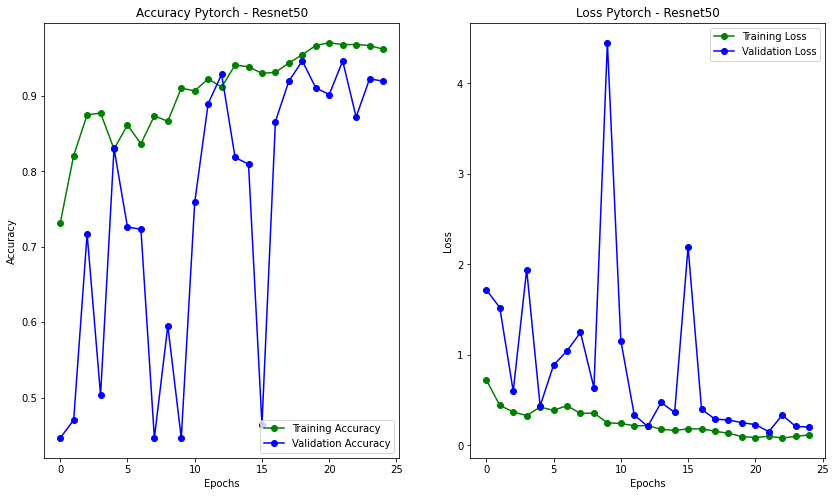

In [54]:
display_plot(history_resnet50, 'Resnet50')